In [48]:
import json
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
data_dir = Path("D:\cricket")
data_dir.mkdir(parents=True, exist_ok=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
print("✅ Libraries imported successfully")
print("=" * 80)

✅ Libraries imported successfully


In [49]:
DATA_PATH = r"D:\cricket\t20s_json"
json_files = glob.glob(os.path.join(DATA_PATH, "*.json"))
print(f"✅ Found {len(json_files)} JSON files")
def load_single_match(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            match_info = {
            'match_id': data.get('meta', {}).get('match_id', Path(file_path).stem),
            'match_type': data.get('info', {}).get('match_type', 'T20'),
            'date': data.get('info', {}).get('dates', [None])[0],
            'venue': data.get('info', {}).get('venue', 'Unknown'),
            'city': data.get('info', {}).get('city', 'Unknown'),
            'toss_winner': data.get('info', {}).get('toss', {}).get('winner'),
            'toss_decision': data.get('info', {}).get('toss', {}).get('decision'),
            'match_winner': data.get('info', {}).get('outcome', {}).get('winner'),
            'teams': data.get('info', {}).get('teams', []),
            'gender': data.get('info', {}).get('gender', 'male'),
            'season': data.get('info', {}).get('season', 'unknown'),
                }
    
        return match_info, data.get('innings', [])

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None
print("\n📋 Testing data load:")
test_file = json_files[0]
match_info, innings_data = load_single_match(test_file)
if match_info:
    print(f"   Match ID: {match_info['match_id']}")
    print(f"   Date: {match_info['date']}")
    print(f"   Teams: {match_info['teams']}")
    print(f"   Winner: {match_info['match_winner']}")
    print(f"   Innings: {len(innings_data)}")

✅ Found 4801 JSON files

📋 Testing data load:
   Match ID: 1001349
   Date: 2017-02-17
   Teams: ['Australia', 'Sri Lanka']
   Winner: Sri Lanka
   Innings: 2


In [50]:
def extract_ball_by_ball_data(file_path):

    match_info, innings_data = load_single_match(file_path)
    if not match_info or not innings_data:
        return []

    all_balls = []

    teams = match_info.get('teams', [])
    team1 = teams[0] if len(teams) > 0 else 'Unknown'
    team2 = teams[1] if len(teams) > 1 else 'Unknown'

    for innings_num, innings in enumerate(innings_data, start=1):
        batting_team = innings.get('team', 'Unknown')
        bowling_team = team2 if batting_team == team1 else team1
    
        # Trackers
        innings_runs = 0
        innings_wickets = 0
        balls_bowled = 0
        recent_runs = []  # For momentum tracking
    
        for over_data in innings.get('overs', []):
            over_num = over_data.get('over', 0)
        
            for delivery_num, delivery in enumerate(over_data.get('deliveries', []), start=1):
            
            # Get current ball info
                runs = delivery.get('runs', {})
                runs_batter = runs.get('batter', 0)
                runs_extras = runs.get('extras', 0)
                runs_total = runs.get('total', 0)
                is_wicket = 1 if 'wickets' in delivery else 0
            
                score_before = innings_runs
                wickets_before = innings_wickets
                balls_before = balls_bowled
            
            # Momentum from PREVIOUS balls only
                runs_last_5 = sum(recent_runs[-5:]) if len(recent_runs) >= 5 else sum(recent_runs)
                runs_last_10 = sum(recent_runs[-10:]) if len(recent_runs) >= 10 else sum(recent_runs)
            
            # NOW update for next ball
                innings_runs += runs_total
                innings_wickets += is_wicket
                balls_bowled += 1
            
            # Create ball record with BEFORE values
                ball_record = {
                # Match identifiers
                'match_id': match_info['match_id'],
                'date': match_info['date'],
                'venue': match_info['venue'],
                'city': match_info['city'],
                
                # Teams
                'batting_team': batting_team,
                'bowling_team': bowling_team,
                'team1': team1,
                'team2': team2,
                
                # Toss
                'toss_winner': match_info['toss_winner'],
                'toss_decision': match_info['toss_decision'],
                
                # Ball identifiers
                'innings': innings_num,
                'over': over_num,
                'ball': delivery_num,
                
                # Current ball outcome (for target creation, not features)
                'runs_batter': runs_batter,
                'runs_extras': runs_extras,
                'runs_total': runs_total,
                'is_wicket': is_wicket,
                
                # ═══ STATE BEFORE BALL (NO LEAKAGE) ═══
                'current_score': score_before,
                'current_wickets': wickets_before,
                'balls_bowled': balls_before,
                'balls_remaining': 120 - balls_before,
                
                # Momentum (from previous balls only)
                'runs_last_5': runs_last_5,
                'runs_last_10':runs_last_10,
                # Target (will be set in 2nd innings)
                'match_winner': match_info['match_winner'],
                }
            
                all_balls.append(ball_record)
            
            # Append AFTER recording
                recent_runs.append(runs_total)

    return all_balls
print("\n📊 Testing ball extraction:")
test_balls = extract_ball_by_ball_data(test_file)
print(f"   Extracted {len(test_balls)} balls")
if test_balls:
    sample = test_balls[10]
    print(f"\n   Sample ball (11th):")
    print(f"      Over.Ball: {sample['over']}.{sample['ball']}")
    print(f"      Score before ball: {sample['current_score']}")
    print(f"      Wickets before ball: {sample['current_wickets']}")
    print(f"      Runs this ball: {sample['runs_total']}")
    print(f"      ✅ No leakage - score doesn't include this ball")



📊 Testing ball extraction:
   Extracted 250 balls

   Sample ball (11th):
      Over.Ball: 1.5
      Score before ball: 7
      Wickets before ball: 0
      Runs this ball: 4
      ✅ No leakage - score doesn't include this ball


In [51]:
def load_all_matches(json_files, max_files=1000):
    all_balls = []
    failed_files = []
    files_to_process = json_files[:max_files] if max_files else json_files

    print(f"\n⏳ Processing {len(files_to_process)} match files...")

    for i, file_path in enumerate(files_to_process):
        if (i + 1) % 500 == 0 or i == 0:
            print(f"   Progress: {i+1}/{len(files_to_process)} files")
    
        balls = extract_ball_by_ball_data(file_path)
    
        if balls:
            all_balls.extend(balls)
        else:
            failed_files.append(file_path)

    print(f"\n✅ Successfully processed {len(files_to_process) - len(failed_files)} files")
    print(f"❌ Failed: {len(failed_files)} files")

    return all_balls, failed_files
print("=" * 80)
print("LOADING ALL MATCH DATA")
print("=" * 80)
all_balls, failed = load_all_matches(json_files, max_files=4801)
df_raw = pd.DataFrame(all_balls)
print(f"\n✅ Created DataFrame:")
print(f"   Shape: {df_raw.shape}")
print(f"   Columns: {len(df_raw.columns)}")
print(f"   Rows: {len(df_raw):,}")

LOADING ALL MATCH DATA

⏳ Processing 4801 match files...
   Progress: 1/4801 files
   Progress: 500/4801 files
   Progress: 1000/4801 files
   Progress: 1500/4801 files
   Progress: 2000/4801 files
   Progress: 2500/4801 files
   Progress: 3000/4801 files
   Progress: 3500/4801 files
   Progress: 4000/4801 files
   Progress: 4500/4801 files

✅ Successfully processed 4801 files
❌ Failed: 0 files

✅ Created DataFrame:
   Shape: (1085959, 24)
   Columns: 24
   Rows: 1,085,959


In [52]:
print("=" * 80)
print("SORTING DATA CHRONOLOGICALLY")
print("=" * 80)
df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce')
df_raw = df_raw.sort_values(
by=['date', 'match_id', 'innings', 'balls_bowled'],
ascending=True
).reset_index(drop=True)
print(f"\n✅ Data sorted chronologically")
print(f"   Date range: {df_raw['date'].min()} to {df_raw['date'].max()}")
print(f"   Matches: {df_raw['match_id'].nunique():,}")

SORTING DATA CHRONOLOGICALLY

✅ Data sorted chronologically
   Date range: 2005-02-17 00:00:00 to 2025-11-27 00:00:00
   Matches: 4,801


In [53]:
print("=" * 80)
print("DATA CLEANING")
print("=" * 80)
df_clean = df_raw.copy()
print(f"\n🧹 Before cleaning: {len(df_clean):,} rows")
df_clean = df_clean.dropna(subset=['date', 'match_winner', 'batting_team', 'venue'])
print(f"   After cleaning: {len(df_clean):,} rows")
print(f"   Removed: {len(df_raw) - len(df_clean):,} rows")
df_clean['city'] = df_clean['city'].fillna('Unknown')
df_clean['runs_last_5'] = df_clean['runs_last_5'].fillna(0)
df_clean['runs_last_5'] = df_clean['runs_last_5'].fillna(0)
print(f"\n✅ Missing values handled")

DATA CLEANING

🧹 Before cleaning: 1,085,959 rows
   After cleaning: 1,065,955 rows
   Removed: 20,004 rows

✅ Missing values handled


In [54]:
print("=" * 80)
print("CALCULATING RUN RATES")
print("=" * 80)
df_clean['current_run_rate'] = np.where(df_clean['balls_bowled'] > 0,(df_clean['current_score'] / df_clean['balls_bowled']) * 6,0)
df_clean['run_rate_last_5'] = np.where(len(df_clean['runs_last_5']) > 0,(df_clean['runs_last_5'] / 5) * 6,0)
df_clean['run_rate_last_10'] = np.where(len(df_clean['runs_last_10']) > 0,(df_clean['runs_last_10'] / 10) * 6,0)
print(f"✅ Run rates calculated")
print(f"   Current RR range: {df_clean['current_run_rate'].min():.2f} - {df_clean['current_run_rate'].max():.2f}")

CALCULATING RUN RATES
✅ Run rates calculated
   Current RR range: 0.00 - 42.00


In [55]:
df_clean['wickets_remaining'] = 10 - df_clean['current_wickets']
print(f"✅ Wickets remaining calculated")
print(f"   Range: {df_clean['wickets_remaining'].min()} - {df_clean['wickets_remaining'].max()}")

✅ Wickets remaining calculated
   Range: 0 - 10


In [56]:
def get_match_phase(over):
    if over < 6:
        return 'powerplay'
    elif over < 16:
        return 'middle'
    else:
        return 'death'
df_clean['match_phase'] = df_clean['over'].apply(get_match_phase)
df_clean['is_powerplay'] = (df_clean['match_phase'] == 'powerplay').astype(int)
df_clean['is_middle'] = (df_clean['match_phase'] == 'middle').astype(int)
df_clean['is_death'] = (df_clean['match_phase'] == 'death').astype(int)
print(f"✅ Match phases created")
print(f"\n   Distribution:")
print(df_clean['match_phase'].value_counts())

✅ Match phases created

   Distribution:
match_phase
middle       541452
powerplay    354776
death        169727
Name: count, dtype: int64


In [57]:
print("=" * 80)
print("CALCULATING TARGET & REQUIRED RUN RATE")
print("=" * 80)
first_innings_totals = df_clean[df_clean['innings'] == 1].groupby('match_id').agg({
'current_score': 'max',  # Final score of 1st innings
}).rename(columns={'current_score': 'first_innings_total'})
df_clean = df_clean.merge(first_innings_totals, on='match_id', how='left')
df_clean['target'] = np.where(df_clean['innings'] == 2,df_clean['first_innings_total'] + 1,0)

df_clean['required_runs'] = np.where(df_clean['innings'] == 2,df_clean['target'] - df_clean['current_score'],0)
df_clean['required_run_rate'] = np.where(
(df_clean['innings'] == 2) & (df_clean['balls_remaining'] > 0),
(df_clean['required_runs'] / df_clean['balls_remaining']) * 6,
0
)
df_clean['required_run_rate'] = df_clean['required_run_rate'].replace([np.inf, -np.inf], 0)
df_clean['required_run_rate'] = df_clean['required_run_rate'].fillna(0)
print(f"✅ Target and RRR calculated for 2nd innings")
print(f"\n   2nd innings samples:")
second_inn = df_clean[df_clean['innings'] == 2].head()
print(f"   Target range: {second_inn['target'].min()} - {second_inn['target'].max()}")
print(f"   Required RR range: {second_inn['required_run_rate'].min():.2f} - {second_inn['required_run_rate'].max():.2f}")
df_clean = df_clean.drop(columns=['first_innings_total'])
print(f"\n✅ Dropped 'first_innings_total' to prevent leakage")

CALCULATING TARGET & REQUIRED RUN RATE
✅ Target and RRR calculated for 2nd innings

   2nd innings samples:
   Target range: 215 - 215
   Required RR range: 10.75 - 11.07

✅ Dropped 'first_innings_total' to prevent leakage


In [58]:
df_clean['toss_winner_batting'] = (
df_clean['batting_team'].astype(str) == df_clean['toss_winner'].astype(str)).astype(int)
df_clean['toss_bat'] = (df_clean['toss_decision'] == 'bat').astype(int)
df_clean['toss_field'] = (df_clean['toss_decision'] == 'field').astype(int)
print(f"✅ Toss features created")

✅ Toss features created


In [59]:
df_clean['year'] = df_clean['date'].dt.year
df_clean['month'] = df_clean['date'].dt.month
df_clean['day_of_week'] = df_clean['date'].dt.dayofweek
print(f"✅ Date features created")

✅ Date features created


In [60]:
print("=" * 80)
print("CREATING TARGET VARIABLE")
print("=" * 80)
df_clean['batting_team_won'] = (
df_clean['batting_team'].astype(str) == df_clean['match_winner'].astype(str)).astype(int)
print(f"\n✅ Target variable created: 'batting_team_won'")
print(f"\n   Distribution:")
print(df_clean['batting_team_won'].value_counts())
print(f"\n   Percentage:")
print(df_clean['batting_team_won'].value_counts(normalize=True) * 100)

CREATING TARGET VARIABLE

✅ Target variable created: 'batting_team_won'

   Distribution:
batting_team_won
0    551389
1    514566
Name: count, dtype: int64

   Percentage:
batting_team_won
0    51.727231
1    48.272769
Name: proportion, dtype: float64


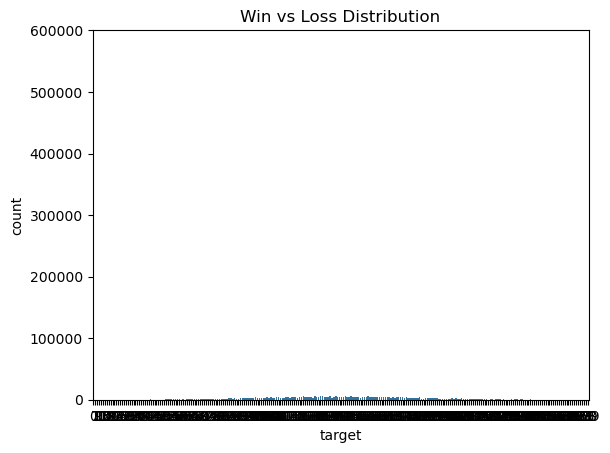

In [61]:
sns.countplot(x=df_clean["target"])
plt.title("Win vs Loss Distribution")
plt.show()


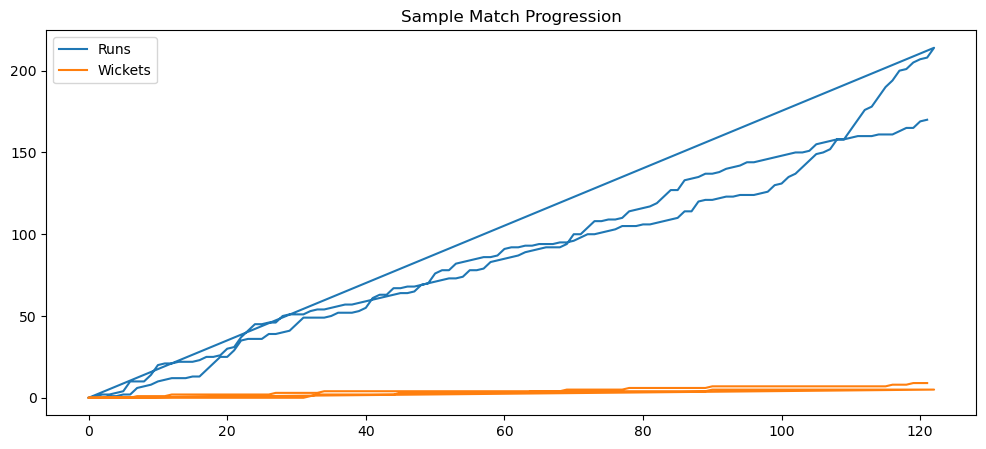

In [62]:
sample = df_clean[df_clean["match_id"] == df_clean["match_id"].iloc[0]]

plt.figure(figsize=(12,5))
plt.plot(sample["balls_bowled"], sample["current_score"], label="Runs")
plt.plot(sample["balls_bowled"], sample["current_wickets"], label="Wickets")
plt.legend()
plt.title("Sample Match Progression")
plt.show()


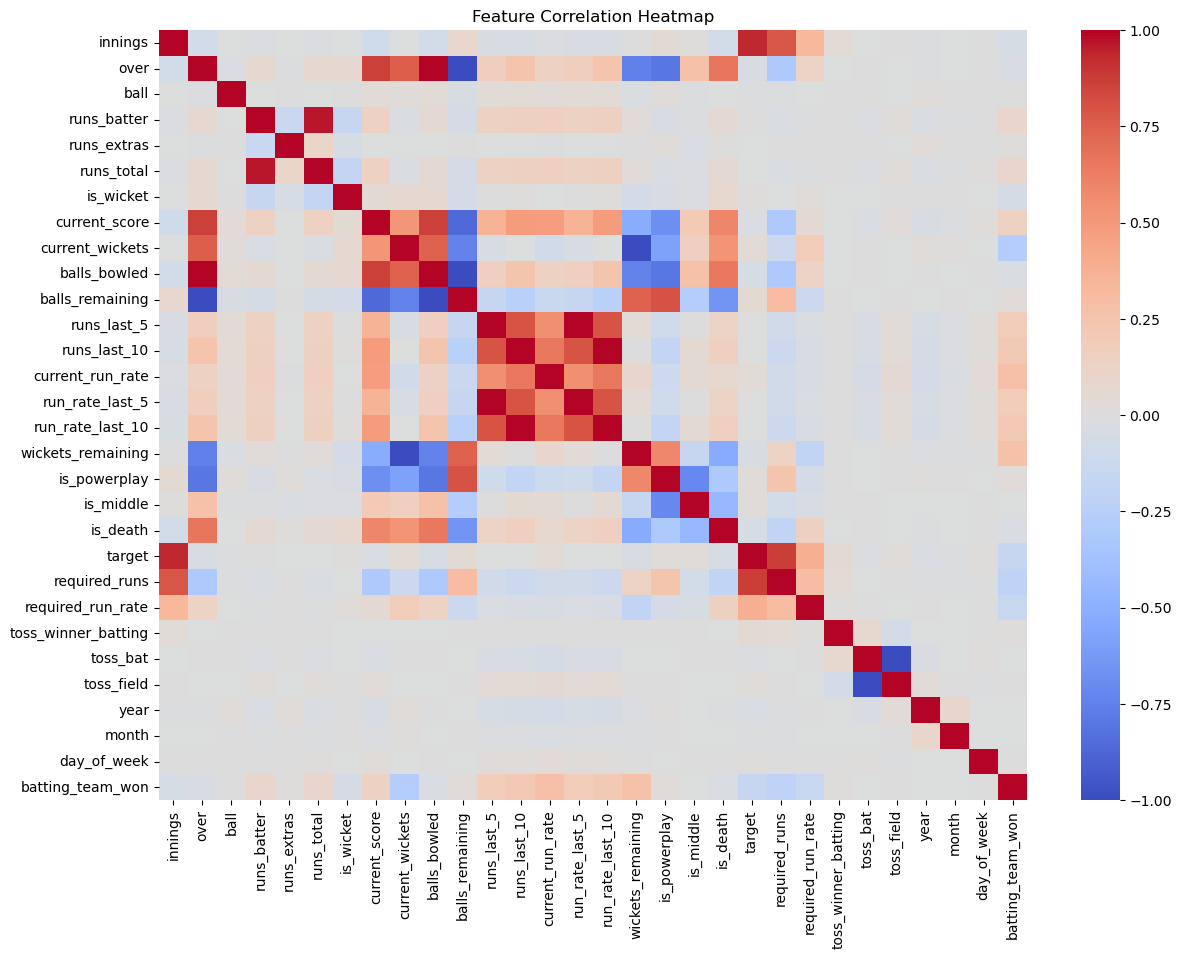

In [63]:
plt.figure(figsize=(14,10))
sns.heatmap(df_clean.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


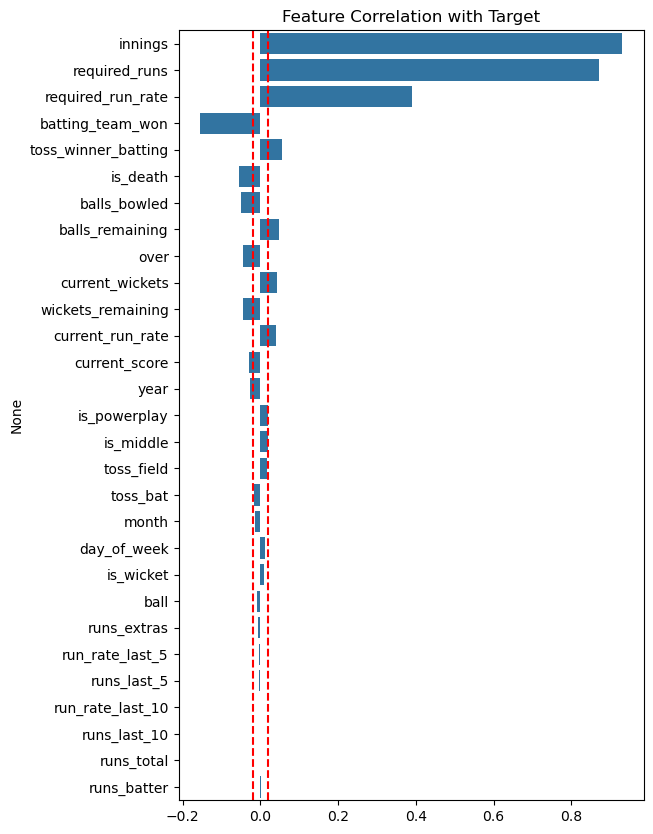

In [64]:
corr_with_target = df_clean.corr(numeric_only=True)["target"].drop("target")
corr_sorted = corr_with_target.sort_values(key=abs, ascending=False)

plt.figure(figsize=(6,10))
sns.barplot(x=corr_sorted.values, y=corr_sorted.index)
plt.title("Feature Correlation with Target")
plt.axvline(0.02, color="red", linestyle="--")
plt.axvline(-0.02, color="red", linestyle="--")
plt.show()


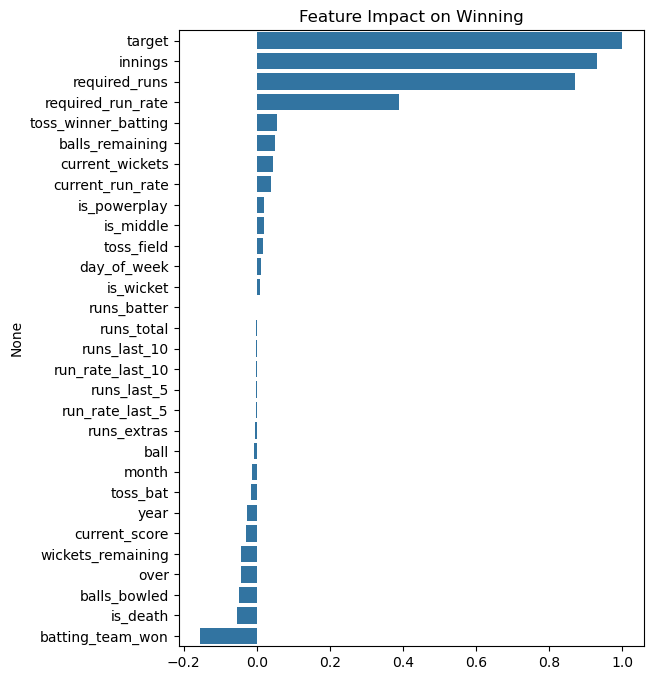

In [65]:
corr = df_clean.corr(numeric_only=True)["target"].sort_values(ascending=False)

plt.figure(figsize=(6,8))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Feature Impact on Winning")
plt.show()


In [66]:

print("=" * 80)
print("AGGREGATING TO MATCH LEVEL (PREVENTS OVERFITTING)")
print("=" * 80)

# Instead of ball-by-ball, take ONE snapshot per match
# Use end of 10th over (mid-innings) as prediction point

match_snapshots = df_clean[
    (df_clean['innings'] == 2) & 
    (df_clean['over'] == 10) & 
    (df_clean['ball'] == 1)
].copy()

print(f"\n📊 Match-level dataset:")
print(f"   Rows: {len(match_snapshots):,} (one per match)")
print(f"   Features: {len(match_snapshots.columns)}")

# If not enough samples at over 10, use over 5
if len(match_snapshots) < 500:
    match_snapshots = df_clean[
        (df_clean['innings'] == 2) & 
        (df_clean['over'] == 5) & 
        (df_clean['ball'] == 1)
    ].copy()
    print(f"   Using over 5 instead: {len(match_snapshots):,} matches")

df_match_level = match_snapshots.copy()

AGGREGATING TO MATCH LEVEL (PREVENTS OVERFITTING)

📊 Match-level dataset:
   Rows: 4,227 (one per match)
   Features: 42


In [67]:
# DROP CORRUPTED TARGET IF EXISTS
df_match_level = df_match_level.drop(columns=['target'], errors='ignore')

# REBUILD TARGET CORRECTLY (binary, per row)
df_match_level['target'] = (
    df_match_level['batting_team'] == df_match_level['match_winner']
).astype(int)

# SANITY CHECK
assert df_match_level['target'].max() <= 1
assert df_match_level['target'].min() >= 0

print("✅ Target rebuilt correctly (binary)")


✅ Target rebuilt correctly (binary)


In [68]:
print("=" * 80)
print("SELECTING FINAL FEATURES")
print("=" * 80)
exclude_cols = ['match_id', 'date','match_winner', 'batting_team_won','batter', 'bowler', 'non_striker','runs_batter', 'runs_extras', 'runs_total', 'is_wicket']
feature_cols = [col for col in df_match_level.columns if col not in exclude_cols]
print(f"\n📋 Feature selection:")
print(f"   Total columns: {len(df_match_level.columns)}")
print(f"   Excluded: {len(exclude_cols)}")
print(f"   Features: {len(feature_cols)}")
print(f"\n✅ Final features ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {col}")

SELECTING FINAL FEATURES

📋 Feature selection:
   Total columns: 42
   Excluded: 11
   Features: 34

✅ Final features (34):
    1. venue
    2. city
    3. batting_team
    4. bowling_team
    5. team1
    6. team2
    7. toss_winner
    8. toss_decision
    9. innings
   10. over
   11. ball
   12. current_score
   13. current_wickets
   14. balls_bowled
   15. balls_remaining
   16. runs_last_5
   17. runs_last_10
   18. current_run_rate
   19. run_rate_last_5
   20. run_rate_last_10
   21. wickets_remaining
   22. match_phase
   23. is_powerplay
   24. is_middle
   25. is_death
   26. required_runs
   27. required_run_rate
   28. toss_winner_batting
   29. toss_bat
   30. toss_field
   31. year
   32. month
   33. day_of_week
   34. target


In [69]:
df_match_level = df_match_level.sort_values(['date', 'match_id']).reset_index(drop=True)


In [70]:

X = df_match_level[feature_cols].reset_index(drop=True)
y = df_match_level['batting_team_won'].astype(int).reset_index(drop=True)
print(f"\n📊 Final dataset prepared:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")

missing = X.isnull().sum().sum()
print(f"\n   Missing values: {missing}")
if missing > 0:
    print(f"   ⚠️  Filling missing values with 0")
    X = X.fillna(0)

inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
print(f"   Infinite values: {inf_count}")
if inf_count > 0:
    print(f"   ⚠️  Replacing infinite values with 0")
    X = X.replace([np.inf, -np.inf], 0)
print(f"\n✅ Data quality verified")


📊 Final dataset prepared:
   X shape: (4227, 34)
   y shape: (4227,)

   Missing values: 0
   Infinite values: 0

✅ Data quality verified


In [71]:
print("=" * 80)
print("TEMPORAL TRAIN-TEST SPLIT")
print("=" * 80)

X_with_date = X.copy()
X_with_date['date'] = df_match_level['date'].values
y_sorted = df_match_level['batting_team_won'].reset_index(drop=True)


split_1 = int(0.70 * len(X_with_date))
split_2 = int(0.85 * len(X_with_date))
train_dates = X_with_date['date'].iloc[:split_1]
val_dates = X_with_date['date'].iloc[split_1:split_2]
test_dates = X_with_date['date'].iloc[split_2:]
print(f"\n📅 Split dates:")
print(f"   Train: {train_dates.min()} to {train_dates.max()}")
print(f"   Val:   {val_dates.min()} to {val_dates.max()}")
print(f"   Test:  {test_dates.min()} to {test_dates.max()}")

X_final = X_with_date.drop(columns=['date'])
X_train = X.iloc[:split_1]
X_val   = X.iloc[split_1:split_2]
X_test  = X.iloc[split_2:]

y_train = y.iloc[:split_1]
y_val   = y.iloc[split_1:split_2]
y_test  = y.iloc[split_2:]
print(f"\n📊 Split sizes:")
print(f"   Train: {X_train.shape} | y: {y_train.shape}")
print(f"   Val:   {X_val.shape} | y: {y_val.shape}")
print(f"   Test:  {X_test.shape} | y: {y_test.shape}")

assert train_dates.max() <= val_dates.min(), "❌ Train-Val overlap!"
assert val_dates.max() <= test_dates.min(), "❌ Val-Test overlap!"
print(f"\n✅ Temporal integrity verified - NO LEAKAGE")

TEMPORAL TRAIN-TEST SPLIT

📅 Split dates:
   Train: 2005-02-17 00:00:00 to 2024-06-01 00:00:00
   Val:   2024-06-02 00:00:00 to 2025-04-07 00:00:00
   Test:  2025-04-07 00:00:00 to 2025-11-27 00:00:00

📊 Split sizes:
   Train: (2958, 34) | y: (2958,)
   Val:   (634, 34) | y: (634,)
   Test:  (635, 34) | y: (635,)

✅ Temporal integrity verified - NO LEAKAGE


In [72]:
print("=" * 80)
print("SAVING PREPARED DATA")
print("=" * 80)
X_train.to_pickle('D:\cricket/X_train.pkl')
X_val.to_pickle('D:\cricket/X_val.pkl')
X_test.to_pickle('D:\cricket/X_test.pkl')
y_train.to_pickle('D:\cricket/y_train.pkl')
y_val.to_pickle('D:\cricket/y_val.pkl')
y_test.to_pickle('D:\cricket/y_test.pkl')
print(f"\n✅ Saved pickle files:")
print(f"   D:\cricket/X_train.pkl")
print(f"   D:\cricket/X_val.pkl")
print(f"   D:\cricket/X_test.pkl")
print(f"  D:\cricket/y_train.pkl")
print(f"   D:\cricket/y_val.pkl")
print(f"   D:\cricket/y_test.pkl")

X_train.to_csv('D:\cricket/X_train.csv', index=False)
X_test.to_csv('D:\cricket/X_test.csv', index=False)

feature_names = X_train.columns.tolist()
with open('D:\cricket/feature_names.json', 'w') as f:
    json.dump(feature_names, f, indent=2)
print(f"✅ Saved feature names: prepared_data/feature_names.json")

SAVING PREPARED DATA

✅ Saved pickle files:
   D:\cricket/X_train.pkl
   D:\cricket/X_val.pkl
   D:\cricket/X_test.pkl
  D:\cricket/y_train.pkl
   D:\cricket/y_val.pkl
   D:\cricket/y_test.pkl
✅ Saved feature names: prepared_data/feature_names.json


In [73]:
print("=" * 80)
print("FINAL VERIFICATION CHECKLIST")
print("=" * 80)
checks = []

#Check 1: No leakage columns
leakage_cols = ['match_winner', 'innings_total', 'first_innings_total', 'runs_total']
found_leakage = [col for col in leakage_cols if col in X_train.columns]
if found_leakage:
    checks.append(("❌", f"Leakage columns found: {found_leakage}"))
else:
    checks.append(("✅", "No leakage columns in features"))

#Check 2: Target distribution
train_pct = y_train.mean() * 100
test_pct = y_test.mean() * 100
if abs(train_pct - test_pct) < 10:
    checks.append(("✅", f"Target balanced: Train={train_pct:.1f}%, Test={test_pct:.1f}%"))
else:
    checks.append(("⚠️", f"Target imbalance: Train={train_pct:.1f}%, Test={test_pct:.1f}%"))

#Check 3: No missing values
if X_train.isnull().sum().sum() == 0:
    checks.append(("✅", "No missing values"))
else:
    checks.append(("❌", f"Missing values: {X_train.isnull().sum().sum()}"))

#Check 4: No infinite values
if np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum() == 0:
    checks.append(("✅", "No infinite values"))
else:
    checks.append(("❌", f"Infinite values found"))

#Check 5: Sufficient data
if len(X_train) > 100 and len(X_test) > 50:
    checks.append(("✅", f"Sufficient data: Train={len(X_train)}, Test={len(X_test)}"))
else:
    checks.append(("⚠️", f"Limited data: Train={len(X_train)}, Test={len(X_test)}"))


#Check 6: Feature count reasonable
if 10 <= X_train.shape[1] <= 50:
    checks.append(("✅", f"Feature count good: {X_train.shape[1]} features"))
elif X_train.shape[1] > 50:
    checks.append(("⚠️", f"Many features: {X_train.shape[1]} (risk of overfitting)"))
else:
    checks.append(("⚠️", f"Few features: {X_train.shape[1]} (may underperform)"))

#Print all checks
print(f"\n")
for status, message in checks:
    print(f"{status} {message}")

#Final summary
all_passed = all(status == "✅" for status, _ in checks)
print(f"\n" + "=" * 80)
if all_passed:
    print("🎉 ALL CHECKS PASSED - DATA IS PRODUCTION-READY!")
else:
    print("⚠️  SOME WARNINGS - REVIEW ABOVE")
print("=" * 80)
print(f"\n✅ DATA PREPARATION COMPLETE")


FINAL VERIFICATION CHECKLIST


✅ No leakage columns in features
✅ Target balanced: Train=47.5%, Test=44.6%
✅ No missing values
✅ No infinite values
✅ Sufficient data: Train=2958, Test=635
✅ Feature count good: 34 features

🎉 ALL CHECKS PASSED - DATA IS PRODUCTION-READY!

✅ DATA PREPARATION COMPLETE
